# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

# Dataset Selection

In [14]:
'''
Linear Regression README:
Modes:
1. Human Observed Dataset
2. GSC
Feature Type:
a. Feature Concat
b. Feature Subs
'''
mode = 2
subMode = 'b'

# Functions

In [15]:
def create_setting_one(master_data,pos_data):
    raw_data_temp = pd.concat([pos_data.set_index('img_id_A'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    raw_data_feature_concat = pd.concat([raw_data_temp.set_index('img_id_B'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    if(np.shape(raw_data_feature_concat)[1] < 25):
        raw_data_feature_concat.drop(['Unnamed: 0'],axis=1,inplace=True)
        num_features = 9 + 1
    else:
        num_features = 512+1
    col_rename = ['img_id_B','img_id_A','target']
    for columns in range(1,len(list(raw_data_feature_concat.columns)[3:])+1):
        if(columns < num_features):
            col_rename.append("fa"+str(columns))
        else:
            col_rename.append("fb"+str(columns - num_features+1))
    raw_data_feature_concat.columns = col_rename
    col_rename.append(col_rename.pop(2))
    temp = col_rename[0]
    col_rename[0] = col_rename[1]
    col_rename[1] = temp
    raw_data_feature_concat = raw_data_feature_concat[col_rename]
    return raw_data_feature_concat

def create_setting_two(raw_data_feature_concat):
    raw_data_feature_subs = pd.concat([raw_data_feature_concat.iloc[:,0:2],raw_data_feature_concat.iloc[:,-1]],axis=1,join='inner').reset_index()
    for columns in range(1,int((len(list(raw_data_feature_concat.columns))-3)/2+1)):
        raw_data_feature_subs['fm'+str(columns)] = abs(raw_data_feature_concat['fa'+str(columns)] - raw_data_feature_concat['fb'+str(columns)])
    col_swap = list(raw_data_feature_subs.columns)[1:]
    col_swap.append(col_swap.pop(2))
    raw_data_feature_subs=raw_data_feature_subs[col_swap]
    return raw_data_feature_subs

def representativeClustering(data,sizeOfTheCluster,seed):
    kmeans = KMeans(n_clusters=sizeOfTheCluster, random_state=seed)
    kmeans_data = kmeans.fit_predict(data.iloc[:,data.columns != 'target'])
    data = data.join(pd.DataFrame(kmeans_data,columns=["kmean_cluster_number"]))
    '''
    2D stratified sampling on the target value and the cluster number so that the algorithm which we will 
    implement will have fair chances of learning all types of data.
    '''
    train,test_val = train_test_split(data,test_size = 0.2,stratify=data[["target","kmean_cluster_number"]],random_state=seed)
    val,test = train_test_split(test_val,test_size = 0.5,stratify=test_val[["target","kmean_cluster_number"]],random_state=seed)
    '''
    Cluster number is not required now
    '''
    train = train.drop(["kmean_cluster_number"],axis=1)
    test = test.drop(["kmean_cluster_number"],axis=1)
    val = val.drop(["kmean_cluster_number"],axis=1)

    mu = kmeans.cluster_centers_
    return train,test,val,mu

# Linear Regression Functions Development
def covar(trainData,num_basis):
    ''' 
    Getting the covar over the training data based on number of basics we have implemented
    Changed the spread for Gaussian radial basis function
    '''
    #print("Using Uniform Gaussian radial basis function")
    train_transpose = np.transpose(trainData)
    iden = np.identity(np.shape(train_transpose)[0])
    for i in range(0,np.shape(train_transpose)[0]):
        # EDIT HERE FOR PRECISION AND NON UNIFORM RADIAL BASICS
        iden[i] = np.dot(iden[i],np.dot(200*i,np.var(train_transpose.iloc[i,:])))
    return iden

def genPhi(train,covarMat,num_basis,mu):
    '''
    Getting the Phi based on the covariance and number of basis
    '''
    phiMat = np.zeros((len(train),int(num_basis))) 
    covarMatInv = np.linalg.pinv(covarMat)
    for i in range(0,num_basis):
        for j in range(0,len(train)):
            subsResult = (np.subtract(train.iloc[j,],mu[i,]))
            L = np.dot(np.transpose(subsResult),covarMatInv)
            R = np.dot(L,subsResult)
            phiMat[j][i] = math.exp(-np.dot(0.5,R))
    return phiMat

def updateWeights(weights,phiMat,train_lab,alpha,lam): 
    midT = np.dot(np.transpose(weights),phiMat)
    deltaL = -(np.subtract(train_lab,midT))
    deltaD = np.dot(float(deltaL),phiMat)
    deltaE = np.transpose(np.matrix(deltaD)) + np.dot(lam,weights)

    delta = np.dot(-alpha,deltaE)
    new_weight = weights + delta
    return new_weight

def GetValTest(VAL_PHI,W):
    Y = np.dot(np.transpose(prev_weight),np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(valData,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(valData)):
        sum = sum + math.pow((ValDataAct[i] - valData[i]),2)
        if(int(np.around(valData[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(valData)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(valData)))),math.sqrt(sum/len(valData))

def plotData(log_erms_train,log_erms_val,log_erms_test):
    writePlot('log_erms_train',log_erms_train)
    writePlot('log_erms_val',log_erms_val)
    writePlot('log_erms_test',log_erms_test)
    return True

def writePlot(filename,log):
    df = pd.DataFrame(log)
    ax = df.plot(figsize=(10,15))
    ax.ticklabel_format(useOffset=False)

    plt.show()
    plt.close("all")

# Generate Heatmap and code to find optimal clusters(Takes very long for GSC therefore commented out)
'''Sum_of_squared_distances = []
K = range(2,16)
for k in K:
    #print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(data.iloc[:,0:len(data.columns)-1])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
# Get The heatmap of corr to determine the clusters
sns.heatmap(np.corrcoef(raw_pos_data.iloc[:,2:-1],raw_neg_data.iloc[:,2:-1],rowvar=False))'''

def epoch_shuffle(train,train_lab,phiMat):
    # Merge
    temp = pd.merge(train.reset_index(),pd.DataFrame(train_lab).reset_index())
    temp.columns.values[-1] = "target"
    temp = pd.merge(temp,pd.DataFrame(phiMat).reset_index())
    temp = temp.sample(frac=1,random_state=431).reset_index().iloc[:,2:]
    if(mode == 1):
        if(subMode == 'a'):
            num_feat = 18
        elif(subMode == 'b'):
            num_feat = 9
    elif(mode == 2):
        if(subMode == 'a'):
            num_feat = 512*2
        elif(subMode == 'b'):
            num_feat = 512
    train = temp.iloc[:,0:num_feat]
    train_lab = np.asarray(temp.iloc[:,num_feat])
    phiMat = np.array(temp.iloc[:,num_feat+1:])
    return train,train_lab,phiMat


# Sampling

In [17]:
'''
Various Setting Generations
Oversampling = o
Perfect i.e 50-50 from pos-neg = p
'''
sampling = 'p'

# Data Processing

In [18]:
# GSC or HOD??
if(mode == 1):
    hum_obs_master_data = pd.read_csv("~/HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv")
    hum_obs_pos_data = pd.read_csv("~/HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")
    hum_obs_neg_data = pd.read_csv("~/HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")
elif(mode ==2):
    gsc_master_data = pd.read_csv("~/GSC-Dataset/GSC-Dataset/GSC-Features-Data/GSC-Features.csv")
    gsc_pos_data = pd.read_csv("~/GSC-Dataset/GSC-Dataset/GSC-Features-Data/same_pairs.csv")
    gsc_neg_data = pd.read_csv("~/GSC-Dataset/GSC-Dataset/GSC-Features-Data/diffn_pairs.csv")
if(mode ==1):
    raw_pos_data = create_setting_one(hum_obs_master_data,hum_obs_pos_data)
    if(sampling == 'o'):
        raw_pos_data = raw_pos_data.append(raw_pos_data).reset_index().iloc[:,1:]
        raw_neg_data = create_setting_one(hum_obs_master_data,hum_obs_neg_data.sample(len(raw_pos_data),random_state = 444))
    if(sampling == 'p'):
        raw_neg_data = create_setting_one(hum_obs_master_data,hum_obs_neg_data.sample(len(raw_pos_data),random_state = 444))
    if(subMode == 'b'):
        raw_pos_data = create_setting_two(raw_pos_data)
        raw_neg_data = create_setting_two(raw_neg_data)
        del hum_obs_master_data,hum_obs_pos_data,hum_obs_neg_data
elif(mode == 2):
# High Memory -> NEED TO FIX
    raw_pos_data = create_setting_one(gsc_master_data,gsc_pos_data)
    if(sampling =='o'):
        raw_pos_data.append(raw_pos_data).reset_index().iloc[:,1:]
        raw_neg_data = create_setting_one(gsc_master_data,gsc_neg_data.sample(len(raw_pos_data),random_state = 444))
    if(sampling == 'p'):
        raw_neg_data = create_setting_one(gsc_master_data,gsc_neg_data.sample(len(raw_pos_data),random_state = 444))
    if(subMode == 'b'):
        raw_pos_data = create_setting_two(raw_pos_data)
        raw_neg_data = create_setting_two(raw_neg_data)
        del gsc_master_data,gsc_pos_data,gsc_neg_data
        
data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
data = data.iloc[:,2:np.shape(data)[1]]

# Clustering

In [19]:
M = 5
data = data.sample(frac=1)
train,test,val,mu = representativeClustering(data=data,sizeOfTheCluster=M,seed=421)
train = train.sample(frac=1,random_state=444).reset_index().iloc[:,1:]
train_lab = train.iloc[:,train.columns == 'target']
val_lab = val.iloc[:,val.columns == 'target']
test_lab = test.iloc[:,test.columns == 'target']
train = train.iloc[:,train.columns != 'target']
val = val.iloc[:,val.columns != 'target']
test = test.iloc[:,test.columns != 'target']
#print(data.head())

# Decision to Normalize the Dataset

In [20]:
'''
Normalize the dataset or not?
Default is False
'''
norm =False
if(norm):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train)
    train = pd.DataFrame(scaler.transform(train),columns=train.columns)
    
train.sample(5,random_state=444)

,fm1,fm2,fm3,fm4,fm5,fm6,fm7,fm8,fm9,fm10,fm11,fm12,fm13,fm14,fm15,fm16,fm17,fm18,fm19,fm20,fm21,fm22,fm23,fm24,fm25,fm26,fm27,fm28,fm29,fm30,fm31,fm32,fm33,fm34,fm35,fm36,fm37,fm38,fm39,fm40,fm41,fm42,fm43,fm44,fm45,fm46,fm47,fm48,fm49,fm50,fm51,fm52,fm53,fm54,fm55,fm56,fm57,fm58,fm59,fm60,fm61,fm62,fm63,fm64,fm65,fm66,fm67,fm68,fm69,fm70,fm71,fm72,fm73,fm74,fm75,fm76,fm77,fm78,fm79,fm80,fm81,fm82,fm83,fm84,fm85,fm86,fm87,fm88,fm89,fm90,fm91,fm92,fm93,fm94,fm95,fm96,fm97,fm98,fm99,fm100,fm101,fm102,fm103,fm104,fm105,fm106,fm107,fm108,fm109,fm110,fm111,fm112,fm113,fm114,fm115,fm116,fm117,fm118,fm119,fm120,fm121,fm122,fm123,fm124,fm125,fm126,fm127,fm128,fm129,fm130,fm131,fm132,fm133,fm134,fm135,fm136,fm137,fm138,fm139,fm140,fm141,fm142,fm143,fm144,fm145,fm146,fm147,fm148,fm149,fm150,fm151,fm152,fm153,fm154,fm155,fm156,fm157,fm158,fm159,fm160,fm161,fm162,fm163,fm164,fm165,fm166,fm167,fm168,fm169,fm170,fm171,fm172,fm173,fm174,fm175,fm176,fm177,fm178,fm179,fm180,fm181,fm182,fm183,fm184,fm185,fm186,fm187,fm188,fm189,fm190,fm191,fm192,fm193,fm194,fm195,fm196,fm197,fm198,fm199,fm200,fm201,fm202,fm203,fm204,fm205,fm206,fm207,fm208,fm209,fm210,fm211,fm212,fm213,fm214,fm215,fm216,fm217,fm218,fm219,fm220,fm221,fm222,fm223,fm224,fm225,fm226,fm227,fm228,fm229,fm230,fm231,fm232,fm233,fm234,fm235,fm236,fm237,fm238,fm239,fm240,fm241,fm242,fm243,fm244,fm245,fm246,fm247,fm248,fm249,fm250,...,fm263,fm264,fm265,fm266,fm267,fm268,fm269,fm270,fm271,fm272,fm273,fm274,fm275,fm276,fm277,fm278,fm279,fm280,fm281,fm282,fm283,fm284,fm285,fm286,fm287,fm288,fm289,fm290,fm291,fm292,fm293,fm294,fm295,fm296,fm297,fm298,fm299,fm300,fm301,fm302,fm303,fm304,fm305,fm306,fm307,fm308,fm309,fm310,fm311,fm312,fm313,fm314,fm315,fm316,fm317,fm318,fm319,fm320,fm321,fm322,fm323,fm324,fm325,fm326,fm327,fm328,fm329,fm330,fm331,fm332,fm333,fm334,fm335,fm336,fm337,fm338,fm339,fm340,fm341,fm342,fm343,fm344,fm345,fm346,fm347,fm348,fm349,fm350,fm351,fm352,fm353,fm354,fm355,fm356,fm357,fm358,fm359,fm360,fm361,fm362,fm363,fm364,fm365,fm366,fm367,fm368,fm369,fm370,fm371,fm372,fm373,fm374,fm375,fm376,fm377,fm378,fm379,fm380,fm381,fm382,fm383,fm384,fm385,fm386,fm387,fm388,fm389,fm390,fm391,fm392,fm393,fm394,fm395,fm396,fm397,fm398,fm399,fm400,fm401,fm402,fm403,fm404,fm405,fm406,fm407,fm408,fm409,fm410,fm411,fm412,fm413,fm414,fm415,fm416,fm417,fm418,fm419,fm420,fm421,fm422,fm423,fm424,fm425,fm426,fm427,fm428,fm429,fm430,fm431,fm432,fm433,fm434,fm435,fm436,fm437,fm438,fm439,fm440,fm441,fm442,fm443,fm444,fm445,fm446,fm447,fm448,fm449,fm450,fm451,fm452,fm453,fm454,fm455,fm456,fm457,fm458,fm459,fm460,fm461,fm462,fm463,fm464,fm465,fm466,fm467,fm468,fm469,fm470,fm471,fm472,fm473,fm474,fm475,fm476,fm477,fm478,fm479,fm480,fm481,fm482,fm483,fm484,fm485,fm486,fm487,fm488,fm489,fm490,fm491,fm492,fm493,fm494,fm495,fm496,fm497,fm498,fm499,fm500,fm501,fm502,fm503,fm504,fm505,fm506,fm507,fm508,fm509,fm510,fm511,fm512
83146,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# Computing Design Matrix and Big Sigma

In [21]:
covarMat = covar(train,M)
#print(" Getting the covar over the training data based on number of basics we have implemented")
#covarMat = covar(train,M)
phiMat = genPhi(train,covarMat,M,mu)
valMat = genPhi(val,covarMat,M,mu)
testMat = genPhi(test,covarMat,M,mu)

In [ ]:
train

# SGD Linear Regression

In [22]:
'''
Appending to a list takes significant amount of time, therefore graph mode has been added and it has
been disabled by default
'''
train_lab = np.asarray(train_lab)
log_erms_val = []
log_erms_train = []
log_erms_test = []
np.random.seed(589)
if(mode == 2):
    if(subMode == 'a'):
        prev_weight = np.zeros((M,1))
else:
    prev_weight = prev_weight = np.zeros((M,1))
'''1 B
alpha = 0.00003
lam = 0.5
sensitivity =  0.001
'''
alpha = 0.000003
lam = 0.5
sensitivity =  0.000001
pErms_Val = 0
nErms_Val = 10
ptrain_erms = 0
ntrain_erms = 10
epoch = 0
ValAccString = ''
TrainAccString = ''
'''
Logging for ERMS Train and Validate should have graphMode enabled
'''

graphMode = True

while(abs(ntrain_erms - ptrain_erms ) > sensitivity):
    print("Epoch: "+str(epoch))
    print(TrainAccString)
    print(ValAccString)
    for i in range(0,len(train)):
        #print("Iteration: "+str(i))
        prev_weight = updateWeights(prev_weight,phiMat[i],train_lab[i],alpha,lam)
        
    if(graphMode):
        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(phiMat,prev_weight) 
        Erms_TR,train_erms       = GetErms(np.transpose(TR_TEST_OUT),np.asarray(train_lab))
        log_erms_train.append(float(train_erms))
        #print ('---------ValidationData Accuracy: ' + Erms_Val + '--------------')
        VAL_TEST_OUT  = GetValTest(valMat,prev_weight) 
        Erms_Val,val_erms      = GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))
        log_erms_val.append(float(val_erms))

        #---------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(testMat,prev_weight) 
        Erms_Test,test_erms = GetErms(np.transpose(TEST_OUT),np.asarray(test_lab))
        log_erms_test.append(float(test_erms))
            
    #train,train_lab,phiMat = epoch_shuffle(train,train_lab,phiMat)
    
    TR_TEST_OUT   = GetValTest(phiMat,prev_weight)
    ptrain_erms = ntrain_erms
    TrainAccString,ntrain_erms       = GetErms(np.transpose(TR_TEST_OUT),np.asarray(train_lab))
    
    VAL_TEST_OUT  = GetValTest(valMat,prev_weight)
    pErms_Val = nErms_Val
    ValAccString,nErms_Val      = GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))
    epoch +=1
    #if(epoch >5):
       # pErms_Val = nErms_Val

Epoch: 0


Epoch: 1
49.99956312418632,0.5019907248329863
50.0,0.5019477163452077
Epoch: 2
49.99956312418632,0.5019536419993991
50.0,0.5019105659965996
Epoch: 3
49.99956312418632,0.5019476458492531
50.0,0.5019045643286104
Epoch: 4
49.99956312418632,0.5019466301943091
50.0,0.501903552285777


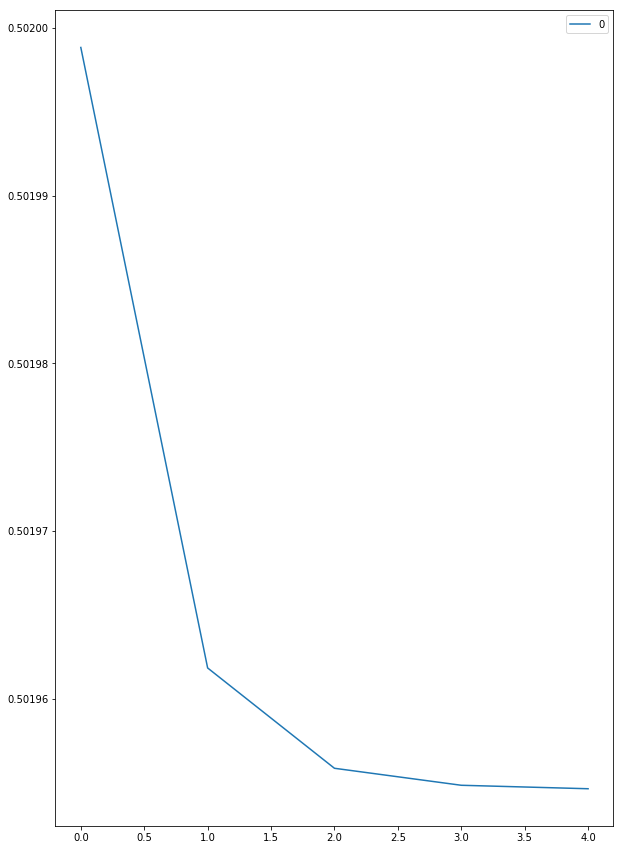

In [23]:
df = pd.DataFrame(log_erms_test)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)

In [ ]:
df = pd.DataFrame(log_erms_val)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)

In [ ]:
df = pd.DataFrame(log_erms_train)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)

In [ ]:
plt.close("all")

In [24]:
TEST_OUT      = GetValTest(testMat,prev_weight) 
Erms_Test,test_erms = GetErms(np.transpose(TEST_OUT),np.asarray(test_lab))

In [27]:
print(test_erms)

0.5019546317412925


In [25]:
conf_mat = confusion_matrix(test_lab.iloc[:,0],np.array(np.round(TEST_OUT.reshape(np.shape(TEST_OUT)[1],1),0)))
conf_mat

array([[7154,    0],
       [7153,    0]])

In [26]:
accuracy  = ((conf_mat[0][0]+conf_mat[1][1])/np.sum(conf_mat))*100
accuracy

50.00349479275879